# Neural network

In [78]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import scipy.io
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fully connected neural network with one hidden layer
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        out, _ = self.lstm(x, (h0,c0))  
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Interpolating data

In [79]:
from scipy import interp

def interpolate_data(data, desired_length):
    # Function to interpolate a single sequence to a desired length
    def interpolate_sequence(sequence, desired_length):
        current_length = len(sequence)
        if current_length < desired_length:
            # Generate indices for interpolation
            indices = np.linspace(0, current_length - 1, current_length)
            new_indices = np.linspace(0, current_length - 1, desired_length)

            # Interpolate using SciPy's interp function
            interpolated_sequence = interp(new_indices, indices, sequence)
            return interpolated_sequence
        return sequence

    # Normalize the length of x and y arrays separately within data
    interpolated_data = []
    for sample in data:
        x_array = sample[0][0]  # Accessing the X component
        y_array = sample[0][1]  # Accessing the Y component

        interpolated_x = interpolate_sequence(x_array, desired_length)
        interpolated_y = interpolate_sequence(y_array, desired_length)

        interpolated_data.append([interpolated_x, interpolated_y])

    # Convert the list of arrays to a NumPy array
    interpolated_data = np.array(interpolated_data)

    return interpolated_data



# Creating subset

In [80]:
from collections import defaultdict

def create_balanced_subset(dataset, size_per_class):
    class_indices = defaultdict(list)
    balanced_indices = []

    # Gather indices for each class
    for idx, (_, label) in enumerate(dataset):
        class_indices[label.item()].append(idx)

    # Select size_per_class samples from each class
    for class_idx in class_indices.values():
        balanced_indices.extend(class_idx[:int(size_per_class)])  # Convert size_per_class to int

    # Create a new subset based on the selected indices
    balanced_subset = torch.utils.data.Subset(dataset, balanced_indices)
    return balanced_subset


def print_class_distribution(dataset):
    class_counts = defaultdict(int)
    for _, label in dataset:
        class_counts[label.item()] += 1

    print("")
    print("Class distribution in the dataset:")
    for class_idx, count in class_counts.items():
        print(f"Class {class_idx + 1}: {count} samples")
    print("Size of dataset:", len(dataset))



# Parameters

In [81]:
# Hyper-parameters 
num_classes = 10
num_epochs = 25
batch_size = 50
learning_rate = 0.001

input_size = 180
sequence_length = 2
num_layers = 2
desired_length = 180

# model
model1 = LSTM(input_size, 128, num_layers, num_classes).to(device)
model2 = LSTM(input_size, 128, num_layers, num_classes).to(device)
model3 = LSTM(input_size, 128, num_layers, num_classes).to(device)

model22 = LSTM(input_size, 64, num_layers, num_classes).to(device)
model23 = LSTM(input_size, 254, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)  
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)   
optimizer22 = torch.optim.Adam(model22.parameters(), lr=learning_rate)  
optimizer23 = torch.optim.Adam(model23.parameters(), lr=learning_rate)   

# Data loading

In [82]:
# Load data from .mat file
mat_data = scipy.io.loadmat('./data_zadanie2_LSTM/DynCislaData_Python.mat')

# Extract data from the loaded dictionary
XTrain = mat_data['XTrain']
XTest = mat_data['XTest']
YTrain = mat_data['YTrain']
YTest = mat_data['YTest']

# Subtract 1 from YTrain and YTest
YTrain -= 1
YTest -= 1

interpolated_XTrain = interpolate_data(XTrain, desired_length)
interpolated_XTest = interpolate_data(XTest, desired_length)

# Convert NumPy arrays to PyTorch tensors
interpolated_XTrain_tensor = torch.tensor(interpolated_XTrain, dtype=torch.float32)
YTrain_tensor = torch.tensor(YTrain, dtype=torch.float32)
interpolated_XTest_tensor = torch.tensor(interpolated_XTest, dtype=torch.float32)
YTest_tensor = torch.tensor(YTest, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(interpolated_XTrain_tensor, YTrain_tensor)
test_dataset = TensorDataset(interpolated_XTest_tensor, YTest_tensor)
subset_150 = create_balanced_subset(train_dataset, 150/num_classes)
print_class_distribution(subset_150)
subset_100 = create_balanced_subset(train_dataset, 100/num_classes)
print_class_distribution(subset_100)

# Create DataLoader for training and testing sets
train_loader_200 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_150 = DataLoader(subset_150, batch_size=batch_size, shuffle=True)
train_loader_100 = DataLoader(subset_100, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Class distribution in the dataset:
Class 2.0: 15 samples
Class 8.0: 15 samples
Class 4.0: 15 samples
Class 5.0: 15 samples
Class 1.0: 15 samples
Class 7.0: 15 samples
Class 3.0: 15 samples
Class 10.0: 15 samples
Class 6.0: 15 samples
Class 9.0: 15 samples
Size of dataset: 150

Class distribution in the dataset:
Class 2.0: 10 samples
Class 8.0: 10 samples
Class 4.0: 10 samples
Class 5.0: 10 samples
Class 1.0: 10 samples
Class 7.0: 10 samples
Class 3.0: 10 samples
Class 10.0: 10 samples
Class 6.0: 10 samples
Class 9.0: 10 samples
Size of dataset: 100


/tmp/ipykernel_17200/1286979885.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interpolated_sequence = interp(new_indices, indices, sequence)


# Train model

In [83]:
def train_model(model, criterion, optimizer, train_loader, num_epochs):
    train_accuracies = []
    train_losses = []

    for epoch in range(num_epochs):
        n_correct = 0
        n_samples = 0
        epoch_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.squeeze(1).long().to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()  # Accumulate the loss for the epoch

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training accuracy for the current batch
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        # Calculate accuracy for the entire training set and average loss per epoch
        train_accuracy = 100.0 * n_correct / n_samples
        avg_epoch_loss = epoch_loss / len(train_loader)

        train_accuracies.append(train_accuracy)
        train_losses.append(avg_epoch_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Training Accuracy: {train_accuracy:.2f} %, Avg Loss: {avg_epoch_loss:.4f}')

    print("")
    return train_accuracies, train_losses


train_accuracies1, train_losses1 = train_model(model1, criterion, optimizer1, train_loader_200, num_epochs)
train_accuracies2, train_losses2 = train_model(model2, criterion, optimizer2, train_loader_150, num_epochs)
train_accuracies3, train_losses3 = train_model(model3, criterion, optimizer3, train_loader_100, num_epochs)

train_accuracies22, train_losses22 = train_model(model22, criterion, optimizer22, train_loader_150, num_epochs)
train_accuracies23, train_losses23 = train_model(model23, criterion, optimizer23, train_loader_150, num_epochs)


Epoch [1/25], Training Accuracy: 26.00 %, Avg Loss: 2.2681
Epoch [2/25], Training Accuracy: 53.00 %, Avg Loss: 2.2040
Epoch [3/25], Training Accuracy: 68.50 %, Avg Loss: 2.1205
Epoch [4/25], Training Accuracy: 78.50 %, Avg Loss: 2.0195
Epoch [5/25], Training Accuracy: 82.00 %, Avg Loss: 1.8931
Epoch [6/25], Training Accuracy: 86.50 %, Avg Loss: 1.7183
Epoch [7/25], Training Accuracy: 83.50 %, Avg Loss: 1.5000
Epoch [8/25], Training Accuracy: 87.50 %, Avg Loss: 1.2652
Epoch [9/25], Training Accuracy: 84.00 %, Avg Loss: 1.0405
Epoch [10/25], Training Accuracy: 88.00 %, Avg Loss: 0.8321
Epoch [11/25], Training Accuracy: 88.00 %, Avg Loss: 0.6980
Epoch [12/25], Training Accuracy: 87.50 %, Avg Loss: 0.6105
Epoch [13/25], Training Accuracy: 89.00 %, Avg Loss: 0.5281
Epoch [14/25], Training Accuracy: 90.00 %, Avg Loss: 0.4438
Epoch [15/25], Training Accuracy: 90.50 %, Avg Loss: 0.3842
Epoch [16/25], Training Accuracy: 91.50 %, Avg Loss: 0.3475
Epoch [17/25], Training Accuracy: 93.00 %, Avg Lo

# Accuracy and loss

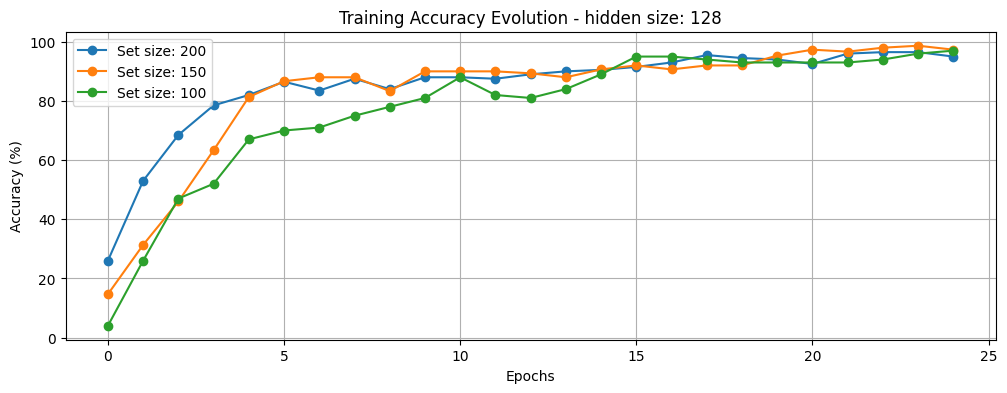

Accuracy of the network on the 98 test data: 95.91836734693878 %
Accuracy of the network on the 98 test data: 95.91836734693878 %
Accuracy of the network on the 98 test data: 94.89795918367346 %


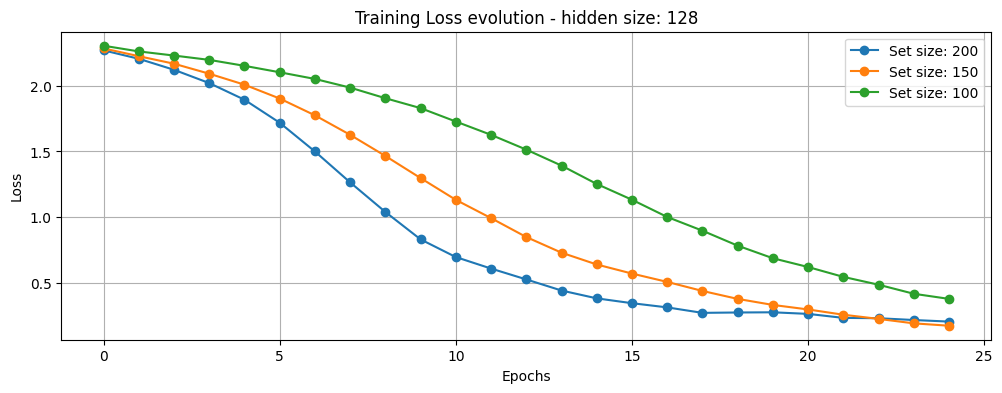

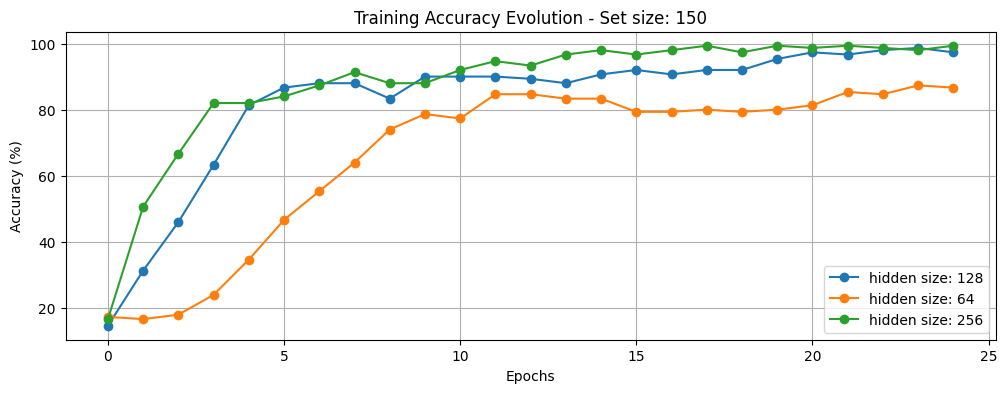

Accuracy of the network on the 98 test data: 95.91836734693878 %
Accuracy of the network on the 98 test data: 82.65306122448979 %
Accuracy of the network on the 98 test data: 93.87755102040816 %


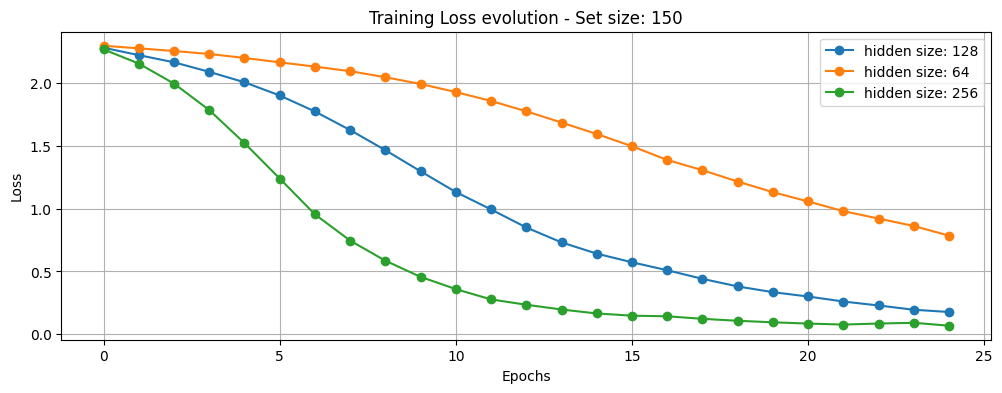

In [84]:
import matplotlib.pyplot as plt

def test_model(model):
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in test_loader:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.squeeze(1).long().to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        accuracy = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network on the {n_samples} test data: {accuracy} %')
        return accuracy


def plot_accuracy(accuracy_list1,accuracy_list2,accuracy_list3):
    plt.figure(figsize=(12, 4))
    plt.plot(accuracy_list1, '-o', label=f'Set size: 200')
    plt.plot(accuracy_list2, '-o', label=f'Set size: 150')
    plt.plot(accuracy_list3, '-o', label=f'Set size: 100')
    plt.title(f'Training Accuracy Evolution - hidden size: 128')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.show() 
    test_model(model1)
    test_model(model2)
    test_model(model3)

def plot_losses(losses_list1,losses_list2,losses_list3):
    plt.figure(figsize=(12, 4))
    plt.plot(losses_list1, '-o', label=f'Set size: 200')
    plt.plot(losses_list2, '-o', label=f'Set size: 150')
    plt.plot(losses_list3, '-o', label=f'Set size: 100')
    plt.title(f'Training Loss evolution - hidden size: 128')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show() 

plot_accuracy(train_accuracies1,train_accuracies2,train_accuracies3)
plot_losses(train_losses1,train_losses2,train_losses3)

def plot_accuracy(accuracy_list1,accuracy_list2,accuracy_list3):
    plt.figure(figsize=(12, 4))
    plt.plot(accuracy_list1, '-o', label=f'hidden size: 128')
    plt.plot(accuracy_list2, '-o', label=f'hidden size: 64')
    plt.plot(accuracy_list3, '-o', label=f'hidden size: 256')
    plt.title(f'Training Accuracy Evolution - Set size: 150')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.show()
    test_model(model2)
    test_model(model22)
    test_model(model23) 

def plot_losses(losses_list1,losses_list2,losses_list3):
    plt.figure(figsize=(12, 4))
    plt.plot(losses_list1, '-o', label=f'hidden size: 128')
    plt.plot(losses_list2, '-o', label=f'hidden size: 64')
    plt.plot(losses_list3, '-o', label=f'hidden size: 256')
    plt.title(f'Training Loss evolution - Set size: 150')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show() 

plot_accuracy(train_accuracies2,train_accuracies22,train_accuracies23)
plot_losses(train_losses2,train_losses22,train_losses23)